# Local GP and Prediction Windows

In [1]:
import gpflow as gpf
import numpy as np

from tsipy.correction import SignalGenerator
from tsipy.fusion import LocalGPModel, SVGPModel, create_windows
from tsipy.fusion.kernels import MultiWhiteKernel
from tsipy.fusion.utils import (
    build_and_concat_label_mask,
    build_and_concat_label_mask_output,
)
from tsipy.utils import sort_inputs, plot_signals, plot_signals_and_confidence

## Parameters

In [2]:
random_seed = 1
pred_window_width = 0.2
fit_window_width = 0.6
normalization = True
clipping = True
n_inducing_pts = 200
max_iter = 2000

## Generate Dataset

In [3]:
signal_generator = SignalGenerator(
    length=10_000, add_degradation=False, random_seed=random_seed
)

x_a, y_a = signal_generator["a"]
x_b, y_b = signal_generator["b"]

x_a = build_and_concat_label_mask(x_a, label=1)
x_b = build_and_concat_label_mask(x_b, label=2)
x_out = build_and_concat_label_mask_output(signal_generator.x)

# Concatenate signals and sort by x[:, 0]
x = np.vstack((x_a, x_b))
y = np.reshape(np.hstack((y_a, y_b)), newshape=(-1, 1))
x, y = sort_inputs(x, y, sort_axis=0)

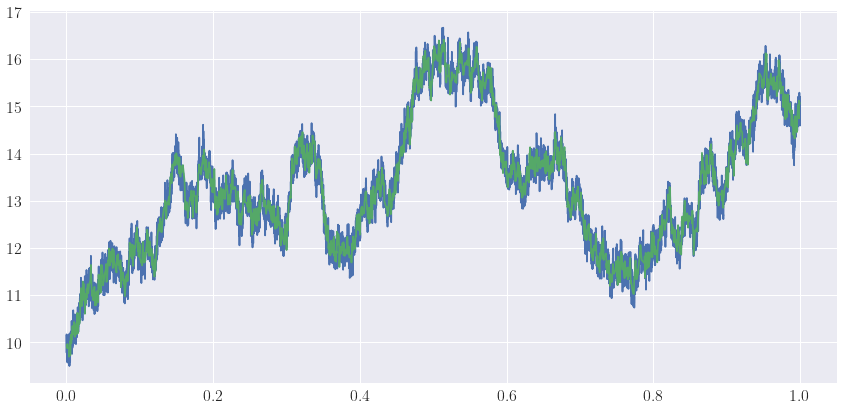

In [4]:
_, ax_ful = plot_signals(
    [
        (x_a[:, 0], y_a, "$a$", {}),
        (x_b[:, 0], y_b, "$b$", {}),
    ],
)

## Create Windows

In [5]:
windows = create_windows(
    x,
    y,
    pred_window_width=pred_window_width,
    fit_window_width=fit_window_width,
    verbose=True,
)


        Data                                      
---------------------------------------------------------------------------
    x:                                            (11025, 2)
        - Range:                                  0.000,    1.000
    y:                                            (11025, 1)
        - Range:                                  9.508,   16.669

        Windows Creation                          
---------------------------------------------------------------------------
Windows:
    Window:                                       0
        - Prediction:                                 -inf,    0.200
        - Training:                                   0.000,    0.400
        - Data indices:                               0,     4446
        - x, y:                                       (4447, 2), (4447, 1)
    Window:                                       1
        - Prediction:                                 0.200,    0.400
        - Training:        

## Visualize Windows

Bounds of prediction windows are shown as solid vertical bars. 
The center of prediction window is the dashed vertical bar. 
For each prediction window, we train a model given the points in the corresponding fit window -- data points in it are shown with a scatter plot.

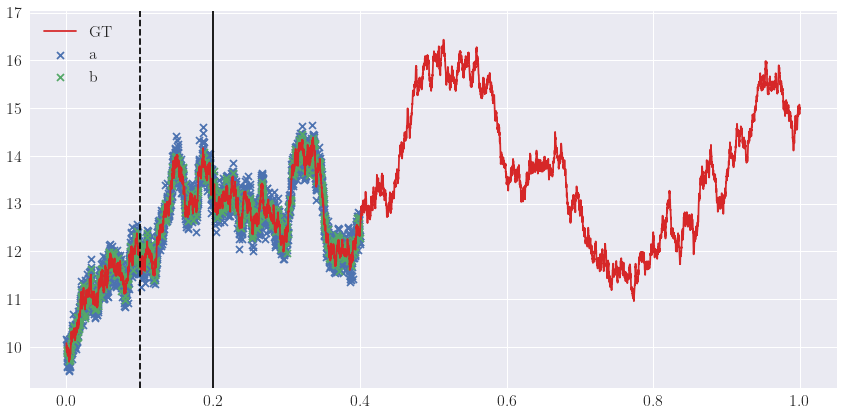

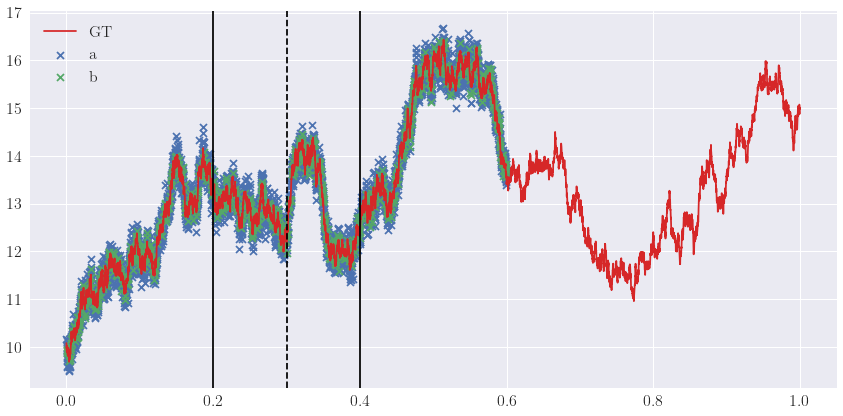

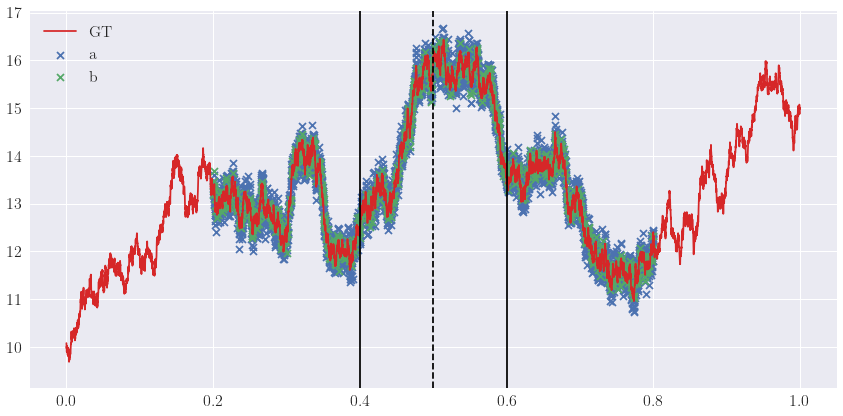

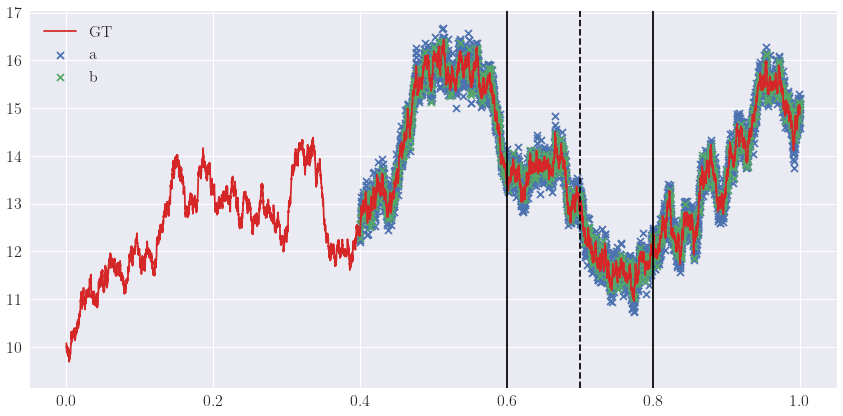

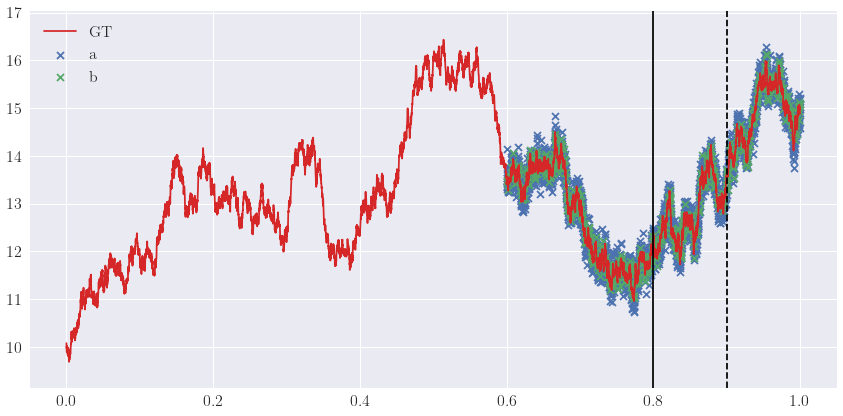

In [6]:
for window in windows:
    x_window = window.x
    y_window = window.y

    fig, ax = plot_signals([
        (signal_generator.x, signal_generator.y, "GT", {"c": "tab:red"})
    ])
    
    for label, label_str in zip([1, 2], ["a", "b"]):
        label_indices = np.equal(x_window[:, 1], label)
    
        ax.scatter(
            x_window[label_indices, 0],
            y_window[label_indices, 0], 
            label=label_str
        )
    
    ax.axvline(x=window.x_pred_start, color="k")
    ax.axvline(x=window.x_pred_end, color="k")
    ax.axvline(x=window.x_pred_mid, color="k", ls="--")
    ax.set_xlim(*ax_ful.get_xlim())
    ax.set_ylim(*ax_ful.get_ylim())
    ax.legend(loc="upper left")

## Visualize Local GP

### Kernel and Fusion Model

In [7]:
# Kernel
matern_kernel = gpf.kernels.Matern12(active_dims=[0])
white_kernel = MultiWhiteKernel(labels=(1, 2), active_dims=[1])
kernel = matern_kernel + white_kernel

# Fusion Model
local_model = SVGPModel(
    kernel=kernel,
    num_inducing_pts=n_inducing_pts,
    normalization=True,
    clipping=True,
)
fusion_model = LocalGPModel(
    model=local_model,
    pred_window_width=pred_window_width,
    fit_window_width=fit_window_width,
    normalization=normalization,
    clipping=clipping,
)

### Training

In [8]:
fusion_model.fit(
    x, y, max_iter=max_iter, random_seed=random_seed, verbose=True
)

y_out_mean, y_out_std = fusion_model(x_out, verbose=True)

Window
    - Prediction:                                 -inf,    0.200
    - Training:                                   0.000,    0.400
    - Data indices:                               0,     4446
    - x, y:                                       (4447, 2), (4447, 1)

    - Step      1/2000:                           -9908.798
    - Step    400/2000:                           -4418.213
    - Step    800/2000:                           -1639.043
    - Step   1200/2000:                           -214.357
    - Step   1600/2000:                           211.228
    - Step   2000/2000:                           57.593
Window
    - Prediction:                                 0.200,    0.400
    - Training:                                   0.000,    0.600
    - Data indices:                               0,     6631
    - x, y:                                       (6632, 2), (6632, 1)

    - Step      1/2000:                           -14693.820
    - Step    400/2000:                 

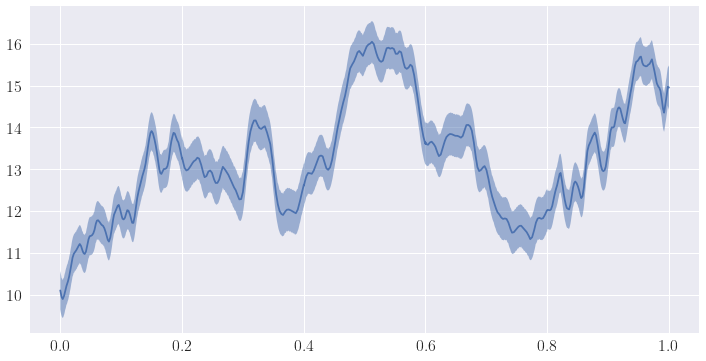

In [9]:
_ = plot_signals_and_confidence(
    [(x_out[:, 0], y_out_mean, y_out_std, "LocalGP")]
)

### Visualize Predictions per Window

A GP model is trained independently in each window. Here, we visualize prediction and training windows.

Window
    - Prediction:                                 -inf,    0.200
    - Training:                                   0.000,    0.400
    - Data indices:                               0,     4446
    - x, y:                                       (4447, 2), (4447, 1)

    - x_window:                                   (10000, 2)
    - y_mean:                                     (10000, 1)
    - y_std:                                      (10000, 1)
Window
    - Prediction:                                 0.200,    0.400
    - Training:                                   0.000,    0.600
    - Data indices:                               0,     6631
    - x, y:                                       (6632, 2), (6632, 1)

    - x_window:                                   (10000, 2)
    - y_mean:                                     (10000, 1)
    - y_std:                                      (10000, 1)
Window
    - Prediction:                                 0.400,    0.600
    - Training: 

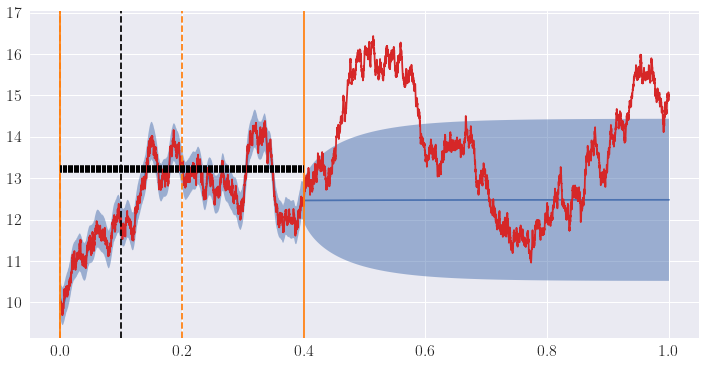

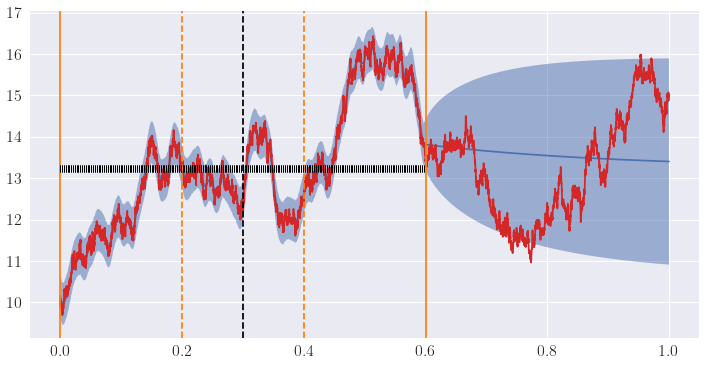

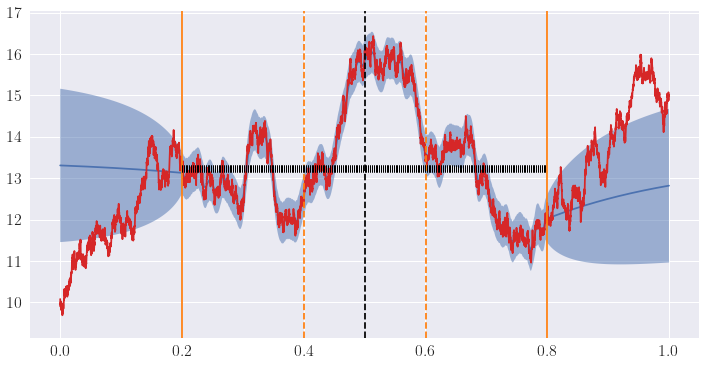

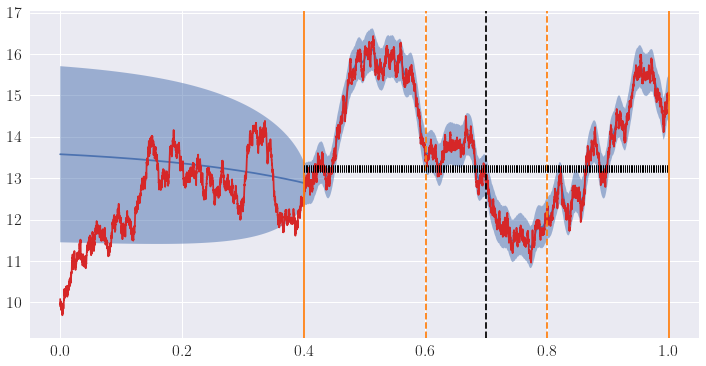

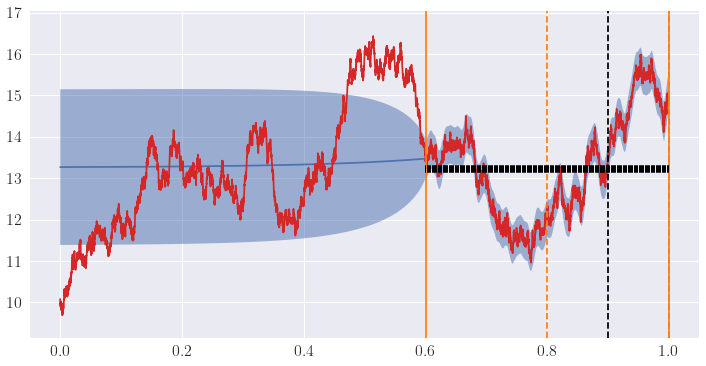

In [10]:
for window_id, window in enumerate(fusion_model.windows):
    y_out_mean_window, y_out_std_window = fusion_model.predict_window(
        x_out, window_id=window_id, verbose=True
    )

    fig, ax = plot_signals_and_confidence(
        [
            (x_out[:, 0], y_out_mean_window, y_out_std_window, "LocalGP-W"),
        ],
    )
    ax.plot(signal_generator.x, signal_generator.y, label="GT", c="tab:red")

    ax.axvline(
        x=max(window.x_pred_start, x_out[0, 0]), color="tab:orange", ls="--"
    )
    ax.axvline(
        x=min(window.x_pred_end, x_out[-1, 0]), color="tab:orange", ls="--"
    )
    ax.axvline(x=window.x_pred_mid, color="k", ls="--")
    ax.axvline(x=max(window.x_fit_start, x_out[0, 0]), color="tab:orange")
    ax.axvline(x=min(window.x_fit_end, x_out[-1, 0]), color="tab:orange")
    ax.set_xlim(*ax_ful.get_xlim())
    ax.set_ylim(*ax_ful.get_ylim())

    if window.model.x_inducing is not None:
        x_inducing = window.model.x_inducing
        x_inducing = window.model._nc.denormalize_x(x_inducing)
        x_inducing = fusion_model._nc.denormalize_x(x_inducing)
        y_inducing = np.mean(y_out_mean) * np.ones_like(x_inducing)

        ax.plot(
            x_inducing[:, 0],
            y_inducing,
            "k|",
            mew=1,
            label="SVGP $x_{ind}$",
        )